In [268]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [269]:
trainDF = pd.read_csv('train.csv')
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [270]:
testDF = pd.read_csv('test.csv')
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [271]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF):
        if 'label' in DF.columns:
            self.x = DF.drop(columns=['label']).values
            self.y = pd.get_dummies(DF['label']).values
        else:
            self.x = DF.values
        pass

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x=torch.FloatTensor(self.x[idx].reshape(1,28,28))

        if hasattr(self,'y'):
            y=torch.FloatTensor(self.y[idx])
            return x,y
        else:
            return x

trainSet= MyDataset(DF=trainDF)
testSet= MyDataset(DF=testDF)
trainSet[0][1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [272]:
trainLoader= torch.utils.data.DataLoader(trainSet,batch_size=1024)
testLoader = torch.utils.data.DataLoader(testSet)
trainLoader

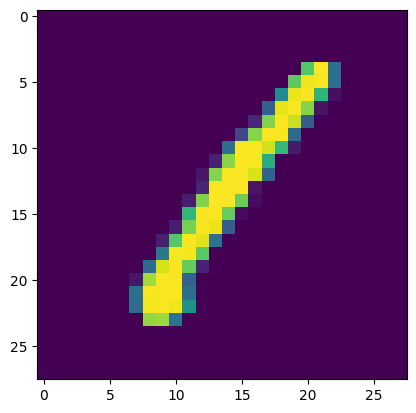

In [273]:
# get some random training images
dataiter = iter(trainLoader)
images, labels = next(dataiter)

# show images
plt.imshow(images[0][0])

In [274]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 3)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 1, 3)
        self.fc1 = torch.nn.Linear(25, 25)
        self.fc2 = torch.nn.Linear(25, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

model = Net().to(device)
print(model)

Using mps device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


In [275]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

In [276]:
def trainAI(dataloader, model, loss_fn, optimizer):
    model.train()
    totalLoss=0
    for  X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        totalLoss +=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        totalLoss+=loss.item()
    print(totalLoss)
    return totalLoss

218.75333166122437
193.33917760849
192.93871212005615
192.57882738113403
192.18683099746704
191.76806259155273
191.3224802017212
190.83702278137207
190.29889154434204
189.70670461654663
189.05584812164307
188.34167575836182
187.56135320663452
186.69930696487427
185.7446732521057
184.66845321655273
183.4190330505371
181.91021823883057
180.05256128311157
177.69413900375366
174.64094495773315
170.77618622779846
166.1145522594452
160.6000349521637
154.51408982276917
148.29489612579346
142.10244369506836
136.28574347496033
130.92974734306335
126.0459520816803
121.59227538108826
117.4701418876648
113.67808818817139
110.18814611434937
107.02458763122559
104.13559484481812
101.44406962394714
98.9331203699112
96.57912981510162
94.3443113565445
92.23372292518616
90.24813294410706
88.33908689022064
86.5278263092041
84.7938779592514
83.10648822784424
81.50120949745178
79.93929600715637
78.42930722236633
76.99963641166687
75.63338041305542
74.33357095718384
73.10405504703522
71.92107939720154
70.80

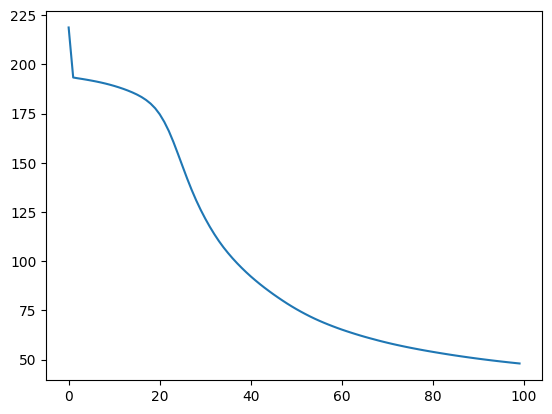

In [277]:
epochs = 100 
totalLoss=[]
for t in range(epochs):
    totalLoss.append(trainAI(trainLoader, model, loss_fn, optimizer))
print("Done!")

plt.plot(totalLoss)

In [278]:
def testAI(dataloader, model ):
    model.eval()
    out = []
    y=1
    with torch.no_grad():
        for X in dataloader:
            X  = X.to(device)
            pred = model(X)
            out.append([y, torch.argmax(pred).item()])
            y+=1
    return out
result = testAI(testLoader, model )
result

[[1, 2],
 [2, 0],
 [3, 9],
 [4, 4],
 [5, 3],
 [6, 7],
 [7, 0],
 [8, 3],
 [9, 0],
 [10, 3],
 [11, 5],
 [12, 7],
 [13, 7],
 [14, 0],
 [15, 4],
 [16, 0],
 [17, 3],
 [18, 1],
 [19, 9],
 [20, 0],
 [21, 9],
 [22, 1],
 [23, 1],
 [24, 3],
 [25, 7],
 [26, 4],
 [27, 2],
 [28, 7],
 [29, 1],
 [30, 7],
 [31, 7],
 [32, 8],
 [33, 4],
 [34, 2],
 [35, 6],
 [36, 2],
 [37, 8],
 [38, 5],
 [39, 1],
 [40, 0],
 [41, 7],
 [42, 7],
 [43, 4],
 [44, 9],
 [45, 8],
 [46, 7],
 [47, 8],
 [48, 2],
 [49, 6],
 [50, 2],
 [51, 6],
 [52, 8],
 [53, 1],
 [54, 3],
 [55, 8],
 [56, 2],
 [57, 1],
 [58, 8],
 [59, 4],
 [60, 5],
 [61, 7],
 [62, 1],
 [63, 7],
 [64, 0],
 [65, 0],
 [66, 0],
 [67, 4],
 [68, 4],
 [69, 0],
 [70, 1],
 [71, 6],
 [72, 5],
 [73, 8],
 [74, 8],
 [75, 2],
 [76, 8],
 [77, 7],
 [78, 9],
 [79, 2],
 [80, 3],
 [81, 5],
 [82, 8],
 [83, 1],
 [84, 0],
 [85, 4],
 [86, 2],
 [87, 4],
 [88, 3],
 [89, 6],
 [90, 7],
 [91, 2],
 [92, 0],
 [93, 6],
 [94, 6],
 [95, 1],
 [96, 4],
 [97, 3],
 [98, 8],
 [99, 7],
 [100, 7],
 [101, 0

In [279]:
result = pd.DataFrame(result)
result = result.astype(int)
result.columns=['ImageId','Label']
result

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
...,...,...
27995,27996,9
27996,27997,9
27997,27998,3
27998,27999,9


In [280]:
result.to_csv('result.csv',index=False)